In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/utkface-new/UTKFace/26_0_2_20170104023102422.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/22_1_1_20170112233644761.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/21_1_3_20170105003215901.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/28_0_0_20170117180555824.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/17_1_4_20170103222931966.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/44_0_3_20170119201022260.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/35_0_2_20170116182734834.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/76_0_0_20170104213515132.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/36_1_0_20170116165722892.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/34_0_3_20170119200815948.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/18_1_0_20170104022856102.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/40_1_1_20170113011948248.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/45_0_0_20170117180013541.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/26_1_1_20170117153641469.jpg.c

In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [3]:
DIR = '/kaggle/input/utkface-new/UTKFace/'

In [5]:
# get labels, age and gender
image_pths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(DIR)):
    img_path = os.path.join(DIR,filename)
    temp = filename.split('_')
    #print(temp)
    age = int(temp[0])
    gender = int(temp[1])
    image_pths.append(img_path)
    age_labels.append(age)
    gender_labels.append(gender)
    

  0%|          | 0/23708 [00:00<?, ?it/s]

In [6]:
df = pd.DataFrame()
df['Image'], df['Age'], df['Gender'] = image_pths, age_labels, gender_labels

In [7]:
gender_dict = {0:'Male',1:'Female'}

In [25]:
from PIL import Image
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image,grayscale=True)
        img = img.resize((64,64),Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features),64,64,1) # only for grayscale no need if RGB is used
    return features

In [26]:
X = extract_features(df['Image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [27]:
X = X/255.0

In [28]:
y_gender = np.array(df['Gender'])
y_age = np.array(df['Age'])

In [29]:
input_shape = (64,64,1)


In [37]:
inputs = Input(shape=input_shape)
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool3)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(128, activation='relu',name='age-model-dense-1')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu',name='age-model-dense-2')(age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu',name='age-model-dense-3')(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu',name='age-model-output')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu',name='gender-model-dense-1')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu',name='gender-model-dense-2')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu',name='gender-model-dense-3')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu',name='gender-model-dense-4')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu',name='gender-model-dense-5')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid',name='gender-model-output')(gender_model)

In [38]:
model = Model(inputs=inputs, outputs=[age_model,gender_model])
model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])

In [39]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 62, 62, 32)   320         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 60, 60, 64)   18496       conv2d_15[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 30, 30, 64)   0           conv2d_16[0][0]                  
____________________________________________________________________________________________

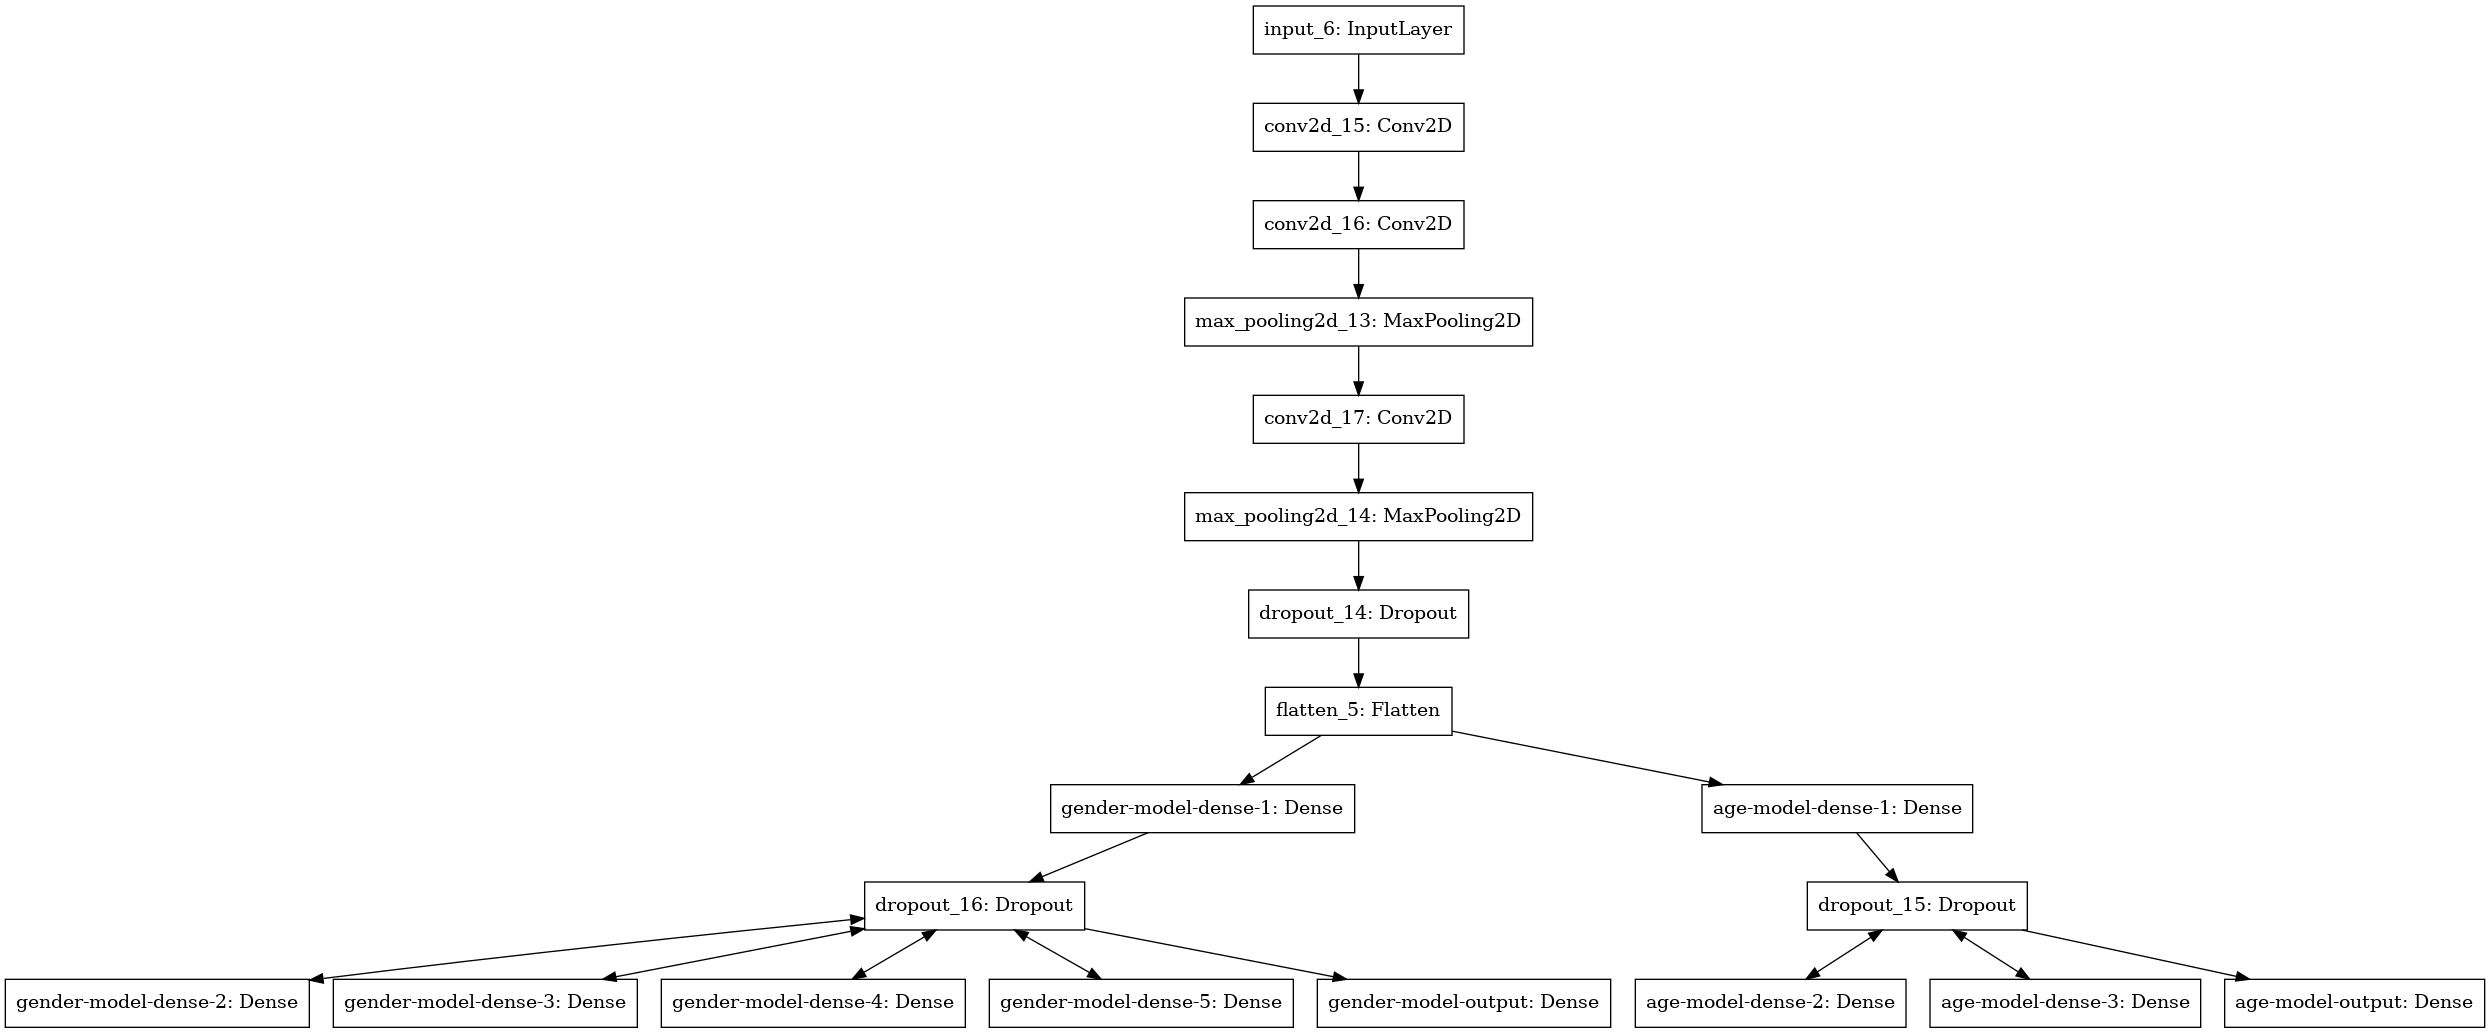

In [40]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [41]:
history = model.fit(x=X,y=[y_age,y_gender],batch_size=128,epochs=25,shuffle=True,validation_split=0.2)

Epoch 1/25
149/149 [==============================] - 5s 28ms/step - loss: 673.3484 - age-model-output_loss: 672.6296 - gender-model-output_loss: 0.7184 - age-model-output_accuracy: 0.0465 - gender-model-output_accuracy: 0.5138 - val_loss: 336.1210 - val_age-model-output_loss: 335.4292 - val_gender-model-output_loss: 0.6918 - val_age-model-output_accuracy: 0.0462 - val_gender-model-output_accuracy: 0.5299
Epoch 2/25
149/149 [==============================] - 4s 25ms/step - loss: 402.8246 - age-model-output_loss: 402.1322 - gender-model-output_loss: 0.6925 - age-model-output_accuracy: 0.0477 - gender-model-output_accuracy: 0.5206 - val_loss: 304.5370 - val_age-model-output_loss: 303.8454 - val_gender-model-output_loss: 0.6916 - val_age-model-output_accuracy: 0.0462 - val_gender-model-output_accuracy: 0.5299
Epoch 3/25
149/149 [==============================] - 4s 25ms/step - loss: 324.0386 - age-model-output_loss: 323.3462 - gender-model-output_loss: 0.6924 - age-model-output_accuracy: 